In [ ]:
# !pip install pillow matplotlib

In [ ]:
!nvidia-smi

Mon Aug 28 18:18:50 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 4000                On  | 00000000:65:00.0  On |                  N/A |
| 30%   35C    P8              15W / 125W |    601MiB /  8192MiB |     16%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
#import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import tensorflow_datasets as tfds
import IPython.display as display

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print("Tensorflow version: ", tf.version.VERSION)

# check TensorRT version
print("TensorRT version: ")
!dpkg -l | grep nvinfer

Tensorflow version:  2.8.0
TensorRT version: 
ii  libnvinfer-bin                    8.2.3-1+cuda11.4                  amd64        TensorRT binaries
ii  libnvinfer-dev                    8.2.3-1+cuda11.4                  amd64        TensorRT development libraries and headers
ii  libnvinfer-plugin-dev             8.2.3-1+cuda11.4                  amd64        TensorRT plugin libraries and headers
ii  libnvinfer-plugin8                8.2.3-1+cuda11.4                  amd64        TensorRT plugin library
ii  libnvinfer8                       8.2.3-1+cuda11.4                  amd64        TensorRT runtime libraries


In [ ]:
tfds.disable_progress_bar()

In [ ]:
import os
#import matplotlib.pyplot

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

from tensorflow.keras import mixed_precision
tf.keras.backend.clear_session()
#mixed_precision.set_global_policy('mixed_float16')


In [ ]:
(ds_train, ds_validation), ds_info = tfds.load('cifar10', split=["train", "test"], as_supervised=True, with_info=True )

In [ ]:
for image, label in ds_train.take(1):  # example is (image, label)
  print(image.shape, label.numpy())

(32, 32, 3) 7


In [ ]:
#index_converter = [0,217,482,491,497,566,569,571,574,701]

In [ ]:
#fig = tfds.show_examples(ds_train, ds_info, rows=4, cols=4)
print(ds_info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



In [ ]:
# import matplotlib.pyplot as plt

# plt.imshow(image.numpy().astype("uint8"))


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (48, 48)
NUM_CLASSES = 10 ##CHANGE #####################################################################################
IMG_SHAPE = IMG_SIZE + (3,)

In [ ]:
def resize_img(image, label):
    return tf.image.resize(image,IMG_SIZE),label

In [ ]:
ds_train = ds_train.map(resize_img)
ds_validation = ds_validation.map(resize_img)

In [ ]:
ds_train = ds_train.batch(BATCH_SIZE)
ds_validation = ds_validation.batch(BATCH_SIZE)

In [ ]:
for image, label in ds_train.take(1):  # example is (image, label)
  print(image.shape, label.numpy())

(32, 48, 48, 3) [7 8 4 4 6 5 2 9 6 6 9 9 3 0 8 7 9 0 4 9 0 8 6 4 2 8 8 7 0 8 4 2]


In [ ]:
# plt.figure(figsize=(10, 10))
# for images, labels in ds_train.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(ds_validation)
ds_test = ds_validation.take(val_batches // 5)
ds_validation = ds_validation.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(ds_validation))
print('Number of test batches: %d' % tf.data.experimental.cardinality(ds_test))

Number of validation batches: 251
Number of test batches: 62


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.prefetch(buffer_size=AUTOTUNE)
ds_validation = ds_validation.prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.05),
])

In [ ]:
# for image, _ in ds_train.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
#     plt.imshow(augmented_image[0] / 255)
#     #plt.imshow(first_image / 255)
#     plt.axis('off')

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 64
IMG_SIZE = (128, 128)
NUM_CLASSES = 2 ##CHANGE #####################################################################################
IMG_SHAPE = IMG_SIZE + (3,)

ds_train = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

ds_validation = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

68616192/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


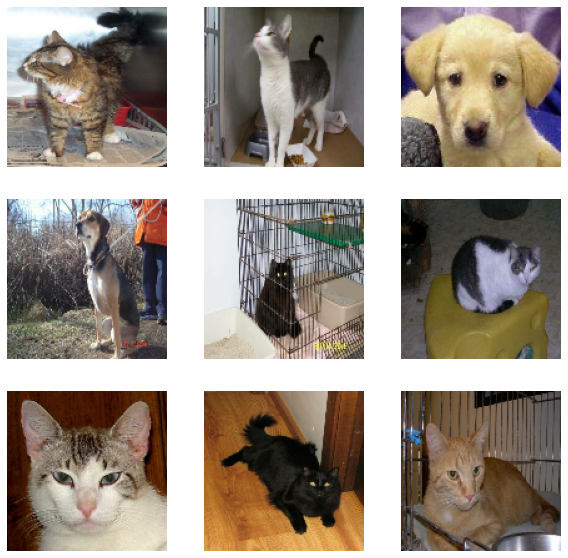

In [ ]:
import matplotlib.pyplot as plt
class_names = ds_train.class_names

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# print(ds_info)

In [ ]:
# val_batches = tf.data.experimental.cardinality(ds_validation)
# ds_test = ds_validation.take(val_batches // 5)
# ds_validation = ds_validation.skip(val_batches // 5)

# print('Number of validation batches: %d' % tf.data.experimental.cardinality(ds_validation))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(ds_test))
# print('Number of Train batches: %d' % tf.data.experimental.cardinality(ds_train))

# AUTOTUNE = tf.data.AUTOTUNE

# ds_train = ds_train.prefetch(buffer_size=AUTOTUNE)
# ds_validation = ds_validation.prefetch(buffer_size=AUTOTUNE)
# ds_test = ds_test.prefetch(buffer_size=AUTOTUNE)

In [ ]:
#plt.imshow(new_image)

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
#import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import tensorflow_datasets as tfds
import IPython.display as display

In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.applications.resnet50 import preprocess_input

# ## Loading MobileNet model
# base_model = ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SHAPE)
# base_model.trainable = True ## trainable weights
# preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

## Loading MobileNet model
base_model = MobileNet(weights="imagenet", include_top=False, input_shape=IMG_SHAPE)
base_model.trainable = True ## trainable weights
preprocess_input = tf.keras.applications.mobilenet.preprocess_input

In [ ]:
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.vgg16 import preprocess_input

# ## Loading VGG16 model
# base_model = VGG16(weights="imagenet", include_top=False, input_shape=IMG_SHAPE)
# base_model.trainable = True ## trainable weights
# preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [ ]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(NUM_CLASSES, activation='softmax')


inputs = tf.keras.Input(shape=IMG_SIZE + (3,)) #IMAGE SIZE
x = preprocess_input(inputs)
x = base_model(x)
x = flatten_layer(x)
x = dense_layer_1(x)
x = dense_layer_2(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # default from_logits=False
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 48, 48, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 48, 48, 3)        0         
 a)                                                              
                                                                 
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                             

In [ ]:
len(model.trainable_variables)

87

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(ds_validation)

251/251 [==============================] - 5s 9ms/step - loss: 2.3141 - accuracy: 0.0761


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.31
initial accuracy: 0.08


In [ ]:
# from tensorflow.keras import mixed_precision
# tf.keras.backend.clear_session()
# mixed_precision.set_global_policy('mixed_float16')

In [ ]:
history = model.fit(ds_train,
                    epochs=initial_epochs,
                    validation_data=ds_validation)

Epoch 1/10
1563/1563 [==============================] - 32s 19ms/step - loss: 1.2386 - accuracy: 0.5872 - val_loss: 0.8031 - val_accuracy: 0.7289
Epoch 2/10
1563/1563 [==============================] - 29s 19ms/step - loss: 0.6687 - accuracy: 0.7746 - val_loss: 0.6395 - val_accuracy: 0.7853
Epoch 3/10
1563/1563 [==============================] - 29s 19ms/step - loss: 0.4300 - accuracy: 0.8543 - val_loss: 0.6332 - val_accuracy: 0.7924
Epoch 4/10
1563/1563 [==============================] - 29s 19ms/step - loss: 0.2791 - accuracy: 0.9058 - val_loss: 0.6335 - val_accuracy: 0.8059
Epoch 5/10
1563/1563 [==============================] - 29s 19ms/step - loss: 0.1924 - accuracy: 0.9353 - val_loss: 0.6216 - val_accuracy: 0.8195
Epoch 6/10
1563/1563 [==============================] - 29s 19ms/step - loss: 0.1442 - accuracy: 0.9509 - val_loss: 0.6981 - val_accuracy: 0.8144
Epoch 7/10
1563/1563 [==============================] - 29s 19ms/step - loss: 0.1254 - accuracy: 0.9561 - val_loss: 0.7025 -

In [ ]:
loss0, accuracy0 = model.evaluate(ds_test)

62/62 [==============================] - 1s 8ms/step - loss: 0.6572 - accuracy: 0.8538


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.66
initial accuracy: 0.85


In [ ]:
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(62, shape=(), dtype=int64)


In [ ]:
from tensorflow.keras.utils import to_categorical
accuracy_sum_base = 0.0
for image, label in ds_test.take(-1):  # example is (image, label)
    #print(image.shape, label.numpy())
    test_labels = to_categorical(label, num_classes=NUM_CLASSES)
    #print(test_labels)
    pred_labels = model.predict(image)
    #print(pred_labels)
    m = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
    m.update_state(test_labels,pred_labels)
    print(m.result().numpy())
    accuracy_sum_base = accuracy_sum_base + m.result().numpy()

accuracy_base = accuracy_sum_base/62.0
#print('Number of Train batches: %d' % tf.data.experimental.cardinality(ds_train))
print('Accruacy of base model: %f',accuracy_base)

0.78125
0.84375
0.75
0.90625
0.96875
0.90625
0.875
0.875
0.875
0.90625
0.90625
0.78125
0.84375
0.875
0.8125
0.78125
0.90625
0.84375
0.84375
0.8125
0.875
1.0
0.90625
0.8125
0.78125
0.8125
0.875
0.90625
0.84375
0.71875
0.8125
0.875
0.78125
0.84375
0.78125
0.84375
0.75
0.9375
0.875
0.8125
0.9375
0.8125
0.90625
0.84375
0.9375
0.8125
0.78125
0.875
0.84375
0.96875
0.84375
0.96875
0.84375
0.71875
0.84375
0.875
0.90625
0.84375
0.875
0.8125
0.875
0.875
Accruacy of base model: %f 0.8538306451612904


In [ ]:
# m = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
# m.update_state(test_labels,
#                pred_labels)
# m.result().numpy()

In [ ]:
# Save the entire model as a SavedModel.
model.save('resnet50_saved_model')

INFO:tensorflow:Assets written to: resnet50_saved_model/assets


INFO:tensorflow:Assets written to: resnet50_saved_model/assets


In [ ]:
model = tf.keras.models.load_model('resnet50_saved_model')

In [ ]:
# Benchmarking throughput
batch_size = BATCH_SIZE
N_warmup_run = 50
N_run = 500
elapsed_time = []

for image, _ in ds_test.take(1):
    batched_input = image
    print(batched_input.shape)

for i in range(N_warmup_run):
  preds = model.predict(batched_input)

for i in range(N_run):
  start_time = time.time()
  preds = model.predict(batched_input)
  end_time = time.time()
  elapsed_time = np.append(elapsed_time, end_time - start_time)
  if i % 50 == 0:
    print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

print('Native TF2.0 saved model')
print('Latency: {:4.1f}ms'.format((elapsed_time.mean()) * 1000))
print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))




In [ ]:
# for image, _ in ds_test.take(1):
#     plt.imshow(image[0].numpy().astype("uint8"))

In [ ]:
# def model_one_pic_time(new_image):
#     yhat = model.predict(new_image, verbose=0)

In [ ]:
# %timeit model_one_pic_time(image)

In [ ]:
print('Converting to TF-TRT FP32...')

conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS
conversion_params = conversion_params._replace(precision_mode="FP32")
conversion_params = conversion_params._replace(minimum_segment_size=3)
converter = trt.TrtGraphConverterV2( input_saved_model_dir='resnet50_saved_model', conversion_params=conversion_params)

#converter = trt.TrtGraphConverterV2(input_saved_model_dir='resnet50_saved_model',
#                                   precision_mode=trt.TrtPrecisionMode.FP32,
#                                    max_workspace_size_bytes=8000000000)

converter.convert()
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP32')
print('Done Converting to TF-TRT FP32')

Converting to TF-TRT FP32...
INFO:tensorflow:Linked TensorRT version: (8, 2, 3)


INFO:tensorflow:Linked TensorRT version: (8, 2, 3)


INFO:tensorflow:Loaded TensorRT version: (8, 2, 3)


INFO:tensorflow:Loaded TensorRT version: (8, 2, 3)


INFO:tensorflow:Could not find TRTEngineOp_0_0 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.


INFO:tensorflow:Could not find TRTEngineOp_0_0 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.


INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP32/assets


INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP32/assets


Done Converting to TF-TRT FP32


In [ ]:
#converter.summary()

In [ ]:
saved_model_loaded = tf.saved_model.load('resnet50_saved_model_TFTRT_FP32', tags=[tag_constants.SERVING])

In [ ]:
for image, _ in ds_test.take(1):
    batched_input = image

In [ ]:
#saved_model_loaded = tf.saved_model.load('resnet50_saved_model_TFTRT_FP32', tags=[tag_constants.SERVING])
signature_keys = list(saved_model_loaded.signatures.keys())
print(signature_keys)

infer = saved_model_loaded.signatures['serving_default']
print(infer.structured_outputs)

labeling = infer(image)
preds = labeling['dense_2'].numpy()
#print('Predicted: {}'.format(decode_predictions(preds, top=1)[0]))
#print(preds)

['serving_default']
{'dense_2': TensorSpec(shape=(None, 10), dtype=tf.float32, name='dense_2')}


In [ ]:
from tensorflow.keras.utils import to_categorical
accuracy_sum_FP32 = 0.0
for image, label in ds_test.take(-1):  # example is (image, label)
    #print(image.shape, label.numpy())
    test_labels = to_categorical(label, num_classes=NUM_CLASSES)
    #print(test_labels)
    labeling = infer(image)
    pred_labels = labeling['dense_2'].numpy()
    #print(pred_labels)
    m = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
    m.update_state(test_labels,pred_labels)
    print(m.result().numpy())
    accuracy_sum_FP32 = accuracy_sum_FP32 + m.result().numpy()

accuracy_FP32 = accuracy_sum_FP32/62.0
#print('Number of Train batches: %d' % tf.data.experimental.cardinality(ds_train))
print('Accuracy of FP32 model: %f',accuracy_FP32)

0.78125
0.84375
0.75
0.90625
0.96875
0.90625
0.875
0.875
0.875
0.90625
0.90625
0.78125
0.84375
0.875
0.8125
0.78125
0.90625
0.84375
0.84375
0.8125
0.875
1.0
0.90625
0.8125
0.78125
0.8125
0.875
0.90625
0.84375
0.71875
0.8125
0.875
0.78125
0.84375
0.78125
0.84375
0.75
0.9375
0.875
0.8125
0.9375
0.8125
0.90625
0.84375
0.9375
0.8125
0.78125
0.875
0.84375
0.96875
0.84375
0.96875
0.84375
0.71875
0.84375
0.875
0.90625
0.84375
0.875
0.8125
0.875
0.875
Accuracy of FP32 model: %f 0.8538306451612904


In [ ]:
def benchmark_tftrt(input_saved_model):
    #saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    for image, _ in ds_test.take(1):
        batched_input = image
        print(batched_input.shape)

    batch_size = BATCH_SIZE
    N_warmup_run = 50
    N_run = 500
    elapsed_time = []

    for i in range(N_warmup_run):
      labeling = infer(batched_input)

    for i in range(N_run):
      start_time = time.time()
      labeling = infer(batched_input)
      end_time = time.time()
      elapsed_time = np.append(elapsed_time, end_time - start_time)
      if i % 50 == 0:
        print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('FP32/FP16 TF2.0 saved model')
    #print(batched_input.shape)
    print('Latency: {:4.1f}ms'.format((elapsed_time.mean()) * 1000))
    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

In [ ]:
benchmark_tftrt('resnet50_saved_model_TFTRT_FP32')

In [ ]:
# for image, _ in ds_test.take(1):
#     batched_input = image

In [ ]:
# def time_tftrt(new_image):
#     labeling = infer(new_image)
#     #preds = labeling['predictions'].numpy()

In [ ]:
# %timeit time_tftrt(image)

In [ ]:
print('Converting to TF-TRT FP16...')

conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS
conversion_params = conversion_params._replace(precision_mode="FP16")
conversion_params = conversion_params._replace(minimum_segment_size=3)
converter = trt.TrtGraphConverterV2( input_saved_model_dir='resnet50_saved_model', conversion_params=conversion_params)

#converter = trt.TrtGraphConverterV2(input_saved_model_dir='resnet50_saved_model',
#                                   precision_mode=trt.TrtPrecisionMode.FP32,
#                                    max_workspace_size_bytes=8000000000)

converter.convert()
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP16')
print('Done Converting to TF-TRT FP16')

Converting to TF-TRT FP16...
INFO:tensorflow:Linked TensorRT version: (8, 2, 3)


INFO:tensorflow:Linked TensorRT version: (8, 2, 3)


INFO:tensorflow:Loaded TensorRT version: (8, 2, 3)


INFO:tensorflow:Loaded TensorRT version: (8, 2, 3)


INFO:tensorflow:Could not find TRTEngineOp_1_0 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.


INFO:tensorflow:Could not find TRTEngineOp_1_0 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.


INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP16/assets


INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP16/assets


Done Converting to TF-TRT FP16


In [ ]:
saved_model_loaded = tf.saved_model.load('resnet50_saved_model_TFTRT_FP16', tags=[tag_constants.SERVING])

In [ ]:
# for image, _ in ds_test.take(1):
#     plt.imshow(image[0].numpy().astype("uint8"))

In [ ]:
#saved_model_loaded = tf.saved_model.load('resnet50_saved_model_TFTRT_FP16', tags=[tag_constants.SERVING])
signature_keys = list(saved_model_loaded.signatures.keys())
print(signature_keys)

infer = saved_model_loaded.signatures['serving_default']
print(infer.structured_outputs)

labeling = infer(image)
#preds = labeling['predictions'].numpy()
#print('Predicted: {}'.format(decode_predictions(preds, top=3)[0]))
#print(preds.shape)

['serving_default']
{'dense_2': TensorSpec(shape=(None, 10), dtype=tf.float32, name='dense_2')}


In [ ]:
from tensorflow.keras.utils import to_categorical
accuracy_sum_FP16 = 0.0
for image, label in ds_test.take(-1):  # example is (image, label)
    #print(image.shape, label.numpy())
    test_labels = to_categorical(label, num_classes=NUM_CLASSES)
    #print(test_labels)
    labeling = infer(image)
    pred_labels = labeling['dense_2'].numpy()
    #print(pred_labels)
    m = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
    m.update_state(test_labels,pred_labels)
    print(m.result().numpy())
    accuracy_sum_FP16 = accuracy_sum_FP16 + m.result().numpy()

accuracy_FP16 = accuracy_sum_FP16/62.0
#print('Number of Train batches: %d' % tf.data.experimental.cardinality(ds_train))
print('Accuracy of FP16 model: %f',accuracy_FP16)

0.78125
0.84375
0.75
0.90625
0.96875
0.90625
0.875
0.875
0.875
0.90625
0.90625
0.78125
0.84375
0.875
0.8125
0.78125
0.90625
0.84375
0.84375
0.8125
0.875
1.0
0.90625
0.8125
0.78125
0.8125
0.875
0.90625
0.84375
0.71875
0.8125
0.875
0.78125
0.84375
0.78125
0.84375
0.75
0.9375
0.875
0.8125
0.9375
0.8125
0.90625
0.84375
0.9375
0.8125
0.78125
0.875
0.84375
0.96875
0.84375
0.96875
0.8125
0.71875
0.84375
0.875
0.90625
0.84375
0.875
0.8125
0.875
0.875
Accuracy of FP16 model: %f 0.8533266129032258


In [ ]:
def benchmark_tftrt(input_saved_model):
    #saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    for image, _ in ds_test.take(1):
        batched_input = image
        print(batched_input.shape)

    batch_size = BATCH_SIZE
    N_warmup_run = 50
    N_run = 500
    elapsed_time = []

    for i in range(N_warmup_run):
      labeling = infer(batched_input)

    for i in range(N_run):
      start_time = time.time()
      labeling = infer(batched_input)
      end_time = time.time()
      elapsed_time = np.append(elapsed_time, end_time - start_time)
      if i % 50 == 0:
        print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('FP32/FP16 TF2.0 saved model')
    #print(batched_input.shape)
    print('Latency: {:4.1f}ms'.format((elapsed_time.mean()) * 1000))
    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))


In [ ]:
benchmark_tftrt('resnet50_saved_model_TFTRT_FP16')

In [ ]:
for image, _ in ds_test.take(1):
    plt.imshow(image[0].numpy().astype("uint8"))

In [ ]:
def time_tftrt(new_image):
    labeling = infer(new_image)
    #preds = labeling['predictions'].numpy()

In [ ]:
%timeit time_tftrt(image)

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
#import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
for image, _ in ds_test.take(1):
    batched_input = image

In [ ]:
def calibration_input_fn():
    yield (batched_input, )

print('Converting to TF-TRT INT8...')

#converter = trt.TrtGraphConverterV2(input_saved_model_dir='resnet50_saved_model', precision_mode=trt.TrtPrecisionMode.INT8, max_workspace_size_bytes=8000000000)

#converter.convert(calibration_input_fn=calibration_input_fn)
#converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_INT8')
#print('Done Converting to TF-TRT INT8')




conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS
conversion_params = conversion_params._replace(precision_mode="INT8")
conversion_params = conversion_params._replace(minimum_segment_size=3)
converter = trt.TrtGraphConverterV2( input_saved_model_dir='resnet50_saved_model', conversion_params=conversion_params)

converter.convert(calibration_input_fn=calibration_input_fn)
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_INT8')
print('Done Converting to TF-TRT INT8')

Converting to TF-TRT INT8...
INFO:tensorflow:Linked TensorRT version: (8, 2, 3)


INFO:tensorflow:Linked TensorRT version: (8, 2, 3)


INFO:tensorflow:Loaded TensorRT version: (8, 2, 3)


INFO:tensorflow:Loaded TensorRT version: (8, 2, 3)


INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_INT8/assets


INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_INT8/assets


Done Converting to TF-TRT INT8


In [ ]:
saved_model_loaded = tf.saved_model.load('resnet50_saved_model_TFTRT_INT8', tags=[tag_constants.SERVING])

In [ ]:
# for image, _ in ds_test.take(1):
#     plt.imshow(image[0].numpy().astype("uint8"))

In [ ]:
#saved_model_loaded = tf.saved_model.load('resnet50_saved_model_TFTRT_INT8', tags=[tag_constants.SERVING])
signature_keys = list(saved_model_loaded.signatures.keys())
print(signature_keys)

infer = saved_model_loaded.signatures['serving_default']
print(infer.structured_outputs)

labeling = infer(image)
#preds = labeling['predictions'].numpy()
#print('Predicted: {}'.format(decode_predictions(preds, top=3)[0]))
#print(preds.shape)

['serving_default']
{'dense_2': TensorSpec(shape=(None, 10), dtype=tf.float32, name='dense_2')}


In [ ]:
from tensorflow.keras.utils import to_categorical
accuracy_sum_INT8 = 0.0
for image, label in ds_test.take(-1):  # example is (image, label)
    #print(image.shape, label.numpy())
    test_labels = to_categorical(label, num_classes=NUM_CLASSES)
    #print(test_labels)
    labeling = infer(image)
    pred_labels = labeling['dense_2'].numpy()
    #print(pred_labels)
    m = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
    m.update_state(test_labels,pred_labels)
    print(m.result().numpy())
    accuracy_sum_INT8 = accuracy_sum_INT8 + m.result().numpy()

accuracy_INT8 = accuracy_sum_INT8/62.0
#print('Number of Train batches: %d' % tf.data.experimental.cardinality(ds_train))
print('Accuracy of INT8 model: %f',accuracy_INT8)

0.78125
0.8125
0.75
0.9375
0.84375
0.875
0.9375
0.84375
0.90625
0.875
0.90625
0.78125
0.84375
0.90625
0.84375
0.78125
0.90625
0.875
0.84375
0.75
0.84375
0.96875
0.84375
0.8125
0.78125
0.8125
0.84375
0.875
0.8125
0.6875
0.78125
0.84375
0.8125
0.75
0.8125
0.8125
0.8125
0.9375
0.84375
0.8125
0.875
0.84375
0.90625
0.8125
0.9375
0.78125
0.78125
0.875
0.84375
0.8125
0.78125
0.96875
0.84375
0.6875
0.84375
0.84375
0.9375
0.75
0.875
0.8125
0.84375
0.875
Accuracy of INT8 model: %f 0.8392137096774194


In [ ]:
def benchmark_tftrt(input_saved_model):
    #saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    for image, _ in ds_test.take(1):
        batched_input = image
        print(batched_input.shape)

    batch_size = BATCH_SIZE
    N_warmup_run = 50
    N_run = 500
    elapsed_time = []

    for i in range(N_warmup_run):
      labeling = infer(batched_input)

    for i in range(N_run):
      start_time = time.time()
      labeling = infer(batched_input)
      end_time = time.time()
      elapsed_time = np.append(elapsed_time, end_time - start_time)
      if i % 50 == 0:
        print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('FP32/FP16 TF2.0 saved model')
    #print(batched_input.shape)
    print('Latency: {:4.1f}ms'.format((elapsed_time.mean()) * 1000))
    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

In [ ]:
benchmark_tftrt('resnet50_saved_model_TFTRT_INT8')

In [ ]:
for image, _ in ds_test.take(1):
    plt.imshow(image[0].numpy().astype("uint8"))

In [ ]:
def time_tftrt(new_image):
    labeling = infer(new_image)
    #preds = labeling['predictions'].numpy()

In [ ]:
%timeit time_tftrt(image)